Cargamos librerias a utilizar, es posible que no utilizemos todas

In [ ]:
pip install stellargraph

     |████████████████████████████████| 435 kB 28.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import FullBatchNodeGenerator, PaddedGraphGenerator
from stellargraph.layer import GCN, GCNSupervisedGraphClassification, DeepGraphCNN

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2,l1,l1_l2
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
#import keras_tuner as kt

from sklearn import preprocessing, model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import class_weight


import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [ ]:
os.chdir("drive/My Drive/UAH/TFM/data/graphs_labels")

In [ ]:
def load_sg_list(path_load, filename):
    open_file=open(path_load+filename,'rb')
    loaded_list=pickle.load(open_file)
    open_file.close()
    return loaded_list

Cargamos las etiquetas creadas anteriormente

In [ ]:
PN00_labels=load_sg_list("", 'PN00_labels.lst')
PN01_labels=load_sg_list("", 'PN01_labels.lst')
PN03_labels=load_sg_list("", 'PN03_labels.lst')
PN05_labels=load_sg_list("", 'PN05_labels.lst')
PN06_labels=load_sg_list("", 'PN06_labels.lst')
PN07_labels=load_sg_list("", 'PN07_labels.lst')
PN09_labels=load_sg_list("", 'PN09_labels.lst')
PN10_labels=load_sg_list("", 'PN10_labels.lst')
PN11_labels=load_sg_list("", 'PN11_labels.lst')
PN12_labels=load_sg_list("", 'PN12_labels.lst')
PN13_labels=load_sg_list("", 'PN13_labels.lst')
PN14_labels=load_sg_list("", 'PN14_labels.lst')
PN16_labels=load_sg_list("", 'PN16_labels.lst')
PN17_labels=load_sg_list("", 'PN17_labels.lst')

In [ ]:
total_labels=PN00_labels+PN01_labels+PN03_labels+PN05_labels+PN06_labels+PN07_labels+PN09_labels+PN10_labels+PN11_labels+PN12_labels+PN13_labels+PN14_labels+PN16_labels+PN17_labels


## Funciones

Cargamos los objetos SG y los asignamos a la variable graphs

In [ ]:
graphs=load_sg_list('','graphs_pearson_deg_sex_agePN10.sg')

Comprobacion del numero de grafos es el mismo que el numero de etiquetas

In [ ]:
len(total_labels)-len(graphs)

0

Convertimos las etiquetas en un DataFrame y luego, asignamos el periodo ictal a interictal para quedarnos con 2 etiquetas y simplificamos con un problema de clasificacion binaria, por ultimo vemos que el set esta desbalanceado con un 70-30 approx.

In [ ]:
graph_labels=pd.DataFrame(total_labels)

In [ ]:
graph_labels_binary=pd.DataFrame(np.where(graph_labels[0]==2,0, graph_labels[0]), columns=['label'])
graph_labels_binary['label']=np.where(graph_labels_binary['label']==1,2, graph_labels_binary['label'])
graph_labels_binary['label']=np.where(graph_labels_binary['label']==0,1, graph_labels_binary['label'])
graph_labels_binary['label']=np.where(graph_labels_binary['label']==2,0, graph_labels_binary['label'])

In [ ]:
graph_labels_binary.value_counts()

label
1        89895
0        37042
dtype: int64

Generamos los set de entrenamiento, validacion y test que seran de 60%,20% y 20% respectivamente

In [ ]:
train_graphs, t_graphs = model_selection.train_test_split(
    graph_labels_binary, train_size=0.60, stratify=graph_labels_binary, random_state=12
)

val_graphs, test_graphs = model_selection.train_test_split(
    t_graphs, train_size=0.5, stratify=t_graphs, random_state=12
)

Creamos el objeto generador y a traves del metodo flow generamos los datos apropiados para keras, como vemos el target esta dentro del objeto generado, que tiene entonces los grafos y sus etiquetas. 

In [ ]:
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graphs.index),
    targets=train_graphs.values,
    batch_size=32,
    weighted=True,
    symmetric_normalization=False
    )

val_gen = gen.flow(
    list(val_graphs.index),
    targets=val_graphs.values,
    batch_size=12,
    weighted=True,
    symmetric_normalization=False
    )

test_gen = gen.flow(
    list(test_graphs.index),
    targets=test_graphs.values,
    batch_size=12,
    weighted=True,
    symmetric_normalization=False
    )

Generamos el modelo de keras con la misma arquitectura del paper de Kipf

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=gen,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

Instructions for updating:
Use fn_output_signature instead


In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=METRICS,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Vamos a agregar un early stopping

In [ ]:
epochs = 10

In [ ]:
es = EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=15,
    mode='max',
    restore_best_weights=True)

Luego procedemos a entrenar

In [ ]:
history = model.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=val_gen, shuffle=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/sort_pooling/map/while/gradients/model_2/sort_pooling/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_2/sort_pooling/map/while/gradients/model_2/sort_pooling/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_2/sort_pooling/map/while/gradients/model_2/sort_pooling/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


2381/2381 [==============================] - 152s 63ms/step - loss: 0.5354 - tp: 51764.0000 - fp: 19357.0000 - tn: 2868.0000 - fn: 2173.0000 - accuracy: 0.7173 - precision: 0.7278 - recall: 0.9597 - auc: 0.7257 - prc: 0.8627 - val_loss: 0.5317 - val_tp: 17575.0000 - val_fp: 6801.0000 - val_tn: 607.0000 - val_fn: 404.0000 - val_accuracy: 0.7162 - val_precision: 0.7210 - val_recall: 0.9775 - val_auc: 0.7323 - val_prc: 0.8697
Epoch 2/10
2381/2381 [==============================] - 153s 64ms/step - loss: 0.5358 - tp: 52074.0000 - fp: 19708.0000 - tn: 2517.0000 - fn: 1863.0000 - accuracy: 0.7168 - precision: 0.7254 - recall: 0.9655 - auc: 0.7250 - prc: 0.8618 - val_loss: 0.5383 - val_tp: 17612.0000 - val_fp: 6832.0000 - val_tn: 576.0000 - val_fn: 367.0000 - val_accuracy: 0.7164 - val_precision: 0.7205 - val_recall: 0.9796 - val_auc: 0.7288 - val_prc: 0.8659
Epoch 3/10
2381/2381 [==============================] - 150s 63ms/step - loss: 0.5359 - tp: 51903.0000 - fp: 19549.0000 - tn: 2676.0000

Utilizamos una utilidad de SG que plotea las learning curves

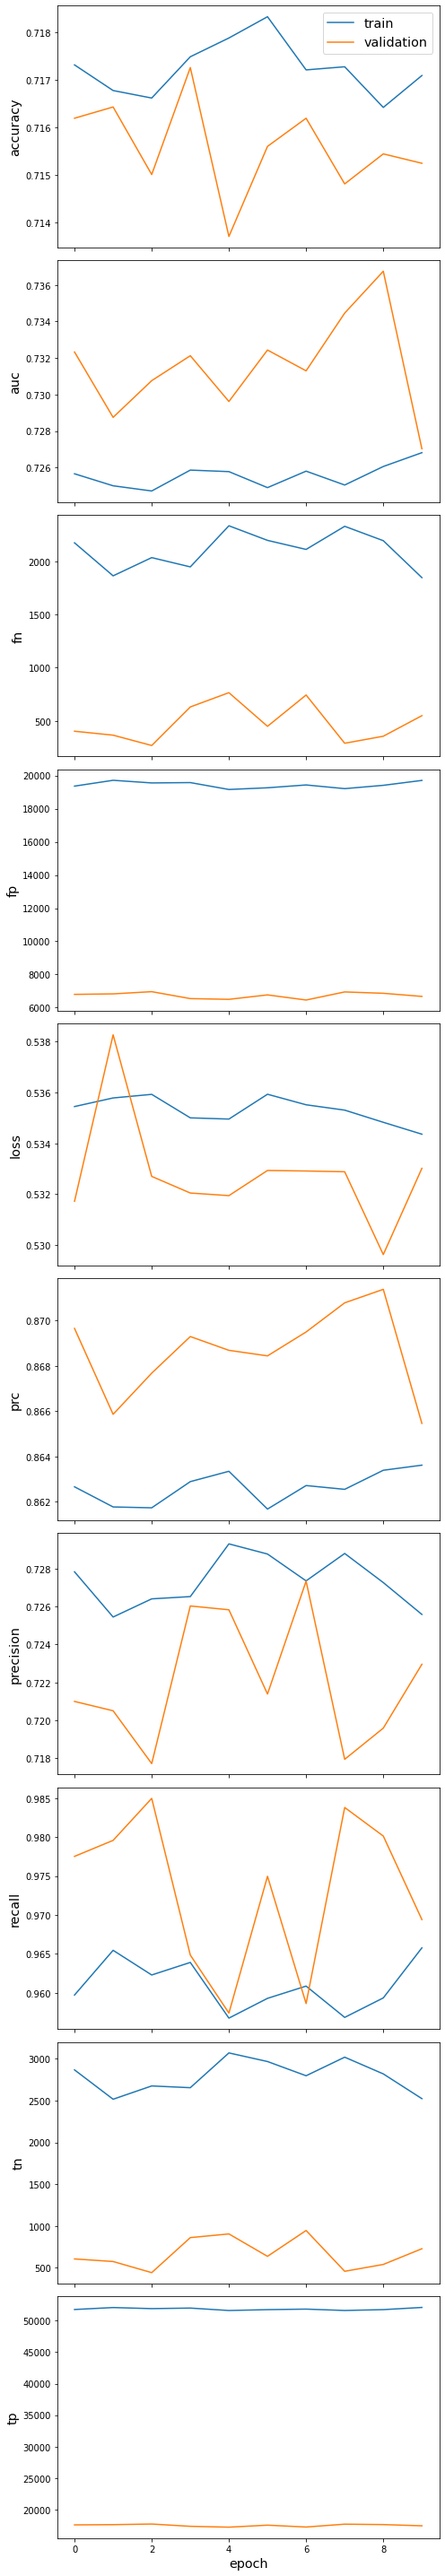

In [ ]:
sg.utils.plot_history(history)#, return_figure=True).savefig('history_pear_coh.png')

Vamos a generar las metricas para entrenamiento, validacion y calculamos las de test

In [ ]:
test_metrics = model.evaluate(test_gen)
val_metrics = model.evaluate(val_gen)
train_metrics = model.evaluate(train_gen)

print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))
    
print("\nVal Set Metrics:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTrain Set Metrics:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))
    



2381/2381 [==============================] - 58s 24ms/step - loss: 0.5318 - tp: 52412.0000 - fp: 19896.0000 - tn: 2329.0000 - fn: 1525.0000 - accuracy: 0.7187 - precision: 0.7248 - recall: 0.9717 - auc: 0.7290 - prc: 0.8657

Test Set Metrics:
	loss: 0.5365
	tp: 17463.0000
	fp: 6635.0000
	tn: 774.0000
	fn: 516.0000
	accuracy: 0.7183
	precision: 0.7247
	recall: 0.9713
	auc: 0.7222
	prc: 0.8611

Val Set Metrics:
	loss: 0.5330
	tp: 17429.0000
	fp: 6679.0000
	tn: 729.0000
	fn: 550.0000
	accuracy: 0.7152
	precision: 0.7230
	recall: 0.9694
	auc: 0.7270
	prc: 0.8655

Train Set Metrics:
	loss: 0.5318
	tp: 52412.0000
	fp: 19896.0000
	tn: 2329.0000
	fn: 1525.0000
	accuracy: 0.7187
	precision: 0.7248
	recall: 0.9717
	auc: 0.7290
	prc: 0.8657


Vamos a generar la matriz de confusion, las filas son True y las columnas Predicted

In [ ]:
lab_pdtrue=pd.DataFrame(model.predict(test_gen), columns=['Predicted'])
lab_pdtrue['True']=test_graphs.values
lab_pdtrue['Predicted']=np.where(lab_pdtrue['Predicted']>0.5,1,0)

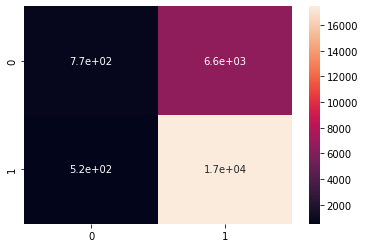

In [ ]:
cmatrix=confusion_matrix(lab_pdtrue['True'],lab_pdtrue['Predicted'])
sns.heatmap(cmatrix, annot=True)